# Data reading and cleaning

In [17]:
import pandas as pd
import numpy as np

file_path = "./archive/USvideos.csv"
usVideos = pd.read_csv(file_path)

# Clean null values and format dates
# print("Raw usVideos")
# print(usVideos)
usVideos = usVideos[usVideos["title"].notna()]
usVideos = usVideos[usVideos["description"].notna()]
usVideos["trending_date"] = pd.to_datetime(usVideos["trending_date"], format="%y.%d.%m")
usVideos["publish_time"] = usVideos["publish_time"].apply(lambda row: row[:-11].replace("T", " "))
usVideos["publish_time"] = pd.to_datetime(usVideos["publish_time"], format="%Y-%m-%d %H") 
usVideos = usVideos[usVideos["video_id"].notna()]
usVideos = usVideos.drop_duplicates(subset=['video_id'])

# Compute features including title lengths, tag lengths, net likes, and trending day differences
usVideos["description_count"] = usVideos["description"].apply(lambda row: len(row))
usVideos["title_count"] = usVideos["title"].apply(lambda row: len(row))
usVideos["channel_title_count"] = usVideos["channel_title"].apply(lambda row: len(row))
usVideos["net_likes"] = usVideos["likes"] - usVideos["dislikes"]
net_col = usVideos["net_likes"]
usVideos["ori_net_likes"] = net_col.copy()
net_col[net_col==0] = 1
usVideos["net_likes"] = net_col.map(lambda x: np.log(x) if x > 0 else -np.log(-x))  # transform scale to a smaller one
popular_thres = 10000
usVideos["popular"] = np.int32(usVideos["net_likes"] > popular_thres)
usVideos["trending_minute_differences"] = usVideos["trending_date"] - usVideos["publish_time"]
usVideos["trending_minute_differences"] = usVideos["trending_minute_differences"].apply(lambda row: row.seconds / 60)
usVideos["tags_count"] = usVideos["tags"].apply(lambda row: len(row.split("|")))
usVideos["tags_avg_length"] = usVideos["tags"].apply(lambda row: np.mean(list(map(lambda x: len(x), row.split("|")))))
boolRows = ["comments_disabled", "ratings_disabled", "video_error_or_removed"]
for i in boolRows:
    usVideos[i] = usVideos[i].astype(int)
# print("usVideos features computed:")
# print(usVideos)

# TODO: Advanced features computations including title_sentiment, channel_title_sentiment, description_sentiment, tags_sentiment

# Select features useful for training
id = ["video_id"]
xs = ["category_id", "comments_disabled", "ratings_disabled", "video_error_or_removed", "title_count", "channel_title_count", "tags_count", "tags_avg_length"]
ys =  ["net_likes"]
vis = ["ori_net_likes"]
# ys =  ["views", "likes", "dislikes", "trending_minute_differences", "net_likes", "popular"]
usVideosCleaned = usVideos[id + xs + ys + vis]
print("usVideos filtered contain:")
print(usVideosCleaned.columns)
print(usVideos.columns)
# print(usVideosCleaned["ori_net_likes"])



usVideos filtered contain:
Index(['video_id', 'category_id', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'title_count', 'channel_title_count',
       'tags_count', 'tags_avg_length', 'net_likes', 'ori_net_likes'],
      dtype='object')
Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'description_count',
       'title_count', 'channel_title_count', 'net_likes', 'ori_net_likes',
       'popular', 'trending_minute_differences', 'tags_count',
       'tags_avg_length'],
      dtype='object')
0         54561
1         91039
2        140694
3          9506
4        130246
          ...  
40760     25271
40761      7381
40762     18412
40764     13513
40766      7863
Name: ori_net_likes, Length: 6254, dtype: int64


C:\Users\NamShoo\AppData\Local\Temp\ipykernel_12404\3415619146.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  net_col[net_col==0] = 1


In [ ]:
# !python -m pip install transformers

In [3]:
# Do sentiment analysis and add the feature
from transformers import pipeline
import copy

id = ["video_id"]
xs = ["category_id", "comments_disabled", "ratings_disabled", "video_error_or_removed", "title_count", "channel_title_count", "tags_count", "tags_avg_length"]
ys =  ["net_likes"]

cols = ["title", "channel_title"]
senti_cols = [i+"_senti" for i in cols]
usVideosSenti = copy.copy(usVideos)
sentiment_pipeline = pipeline("sentiment-analysis")
lab_map = {"POSITIVE": 1, "NEGATIVE": -1}
for j, k in zip(cols, senti_cols):
    print(usVideosSenti[j].tolist())
    print(len(usVideosSenti[j].tolist()))
    senti = sentiment_pipeline(usVideosSenti[j].tolist())
    print(senti)
    sens = [m["score"]*lab_map[m["label"]] for m in senti]
    usVideosSenti[k] = sens





No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


['WE WANT TO TALK ABOUT OUR MARRIAGE', 'The Trump Presidency: Last Week Tonight with John Oliver (HBO)', 'Racist Superman | Rudy Mancuso, King Bach & Lele Pons', 'Nickelback Lyrics: Real or Fake?', 'I Dare You: GOING BALD!?', '2 Weeks with iPhone X', 'Roy Moore & Jeff Sessions Cold Open - SNL', '5 Ice Cream Gadgets put to the Test', 'The Greatest Showman | Official Trailer 2 [HD] | 20th Century FOX', 'Why the rise of the robots won’t mean the end of work', "Dion Lewis' 103-Yd Kick Return TD vs. Denver! | Can't-Miss Play | NFL Wk 10 Highlights", "(SPOILERS) 'Shiva Saves the Day' Talked About Scene Ep. 804 | The Walking Dead", 'Marshmello - Blocks (Official Music Video)', 'Which Countries Are About To Collapse?', 'SHOPPING FOR NEW FISH!!!', 'The New SpotMini', 'One Change That Would Make Pacific Rim a Classic', "How does your body know you're full? - Hilary Coller", 'HomeMade Electric Airplane', 'Founding An Inbreeding-Free Space Colony', 'How Can You Control Your Dreams?', "The Making o

In [18]:
usVideosSenti.columns

cols = ["title", "channel_title"]
senti_cols = [i+"_senti" for i in cols]
xnews = xs + senti_cols
# xnews
usVideosSenti = usVideosSenti[id + xnews + ys]
usVideosSenti.columns
usVideosSenti["ori_net_likes"] = usVideosCleaned["ori_net_likes"]
# usVideosSentiFeats['title_senti']
usVideosCleaned = usVideosSenti
# usVideosCleaned = usVideosSentiFeats
# print(usVideosSenti["ori_net_likes"])

0         54561
1         91039
2        140694
3          9506
4        130246
          ...  
40760     25271
40761      7381
40762     18412
40764     13513
40766      7863
Name: ori_net_likes, Length: 6254, dtype: int64


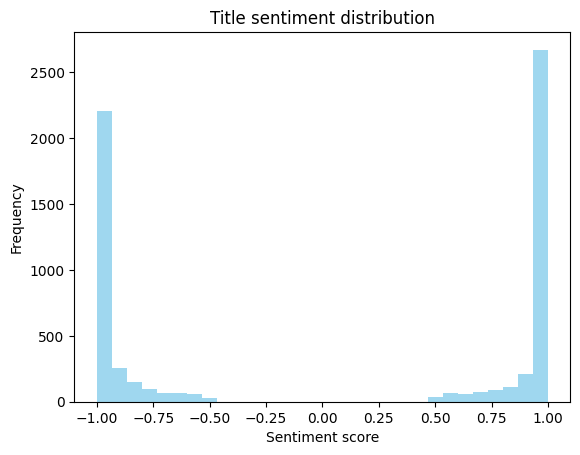

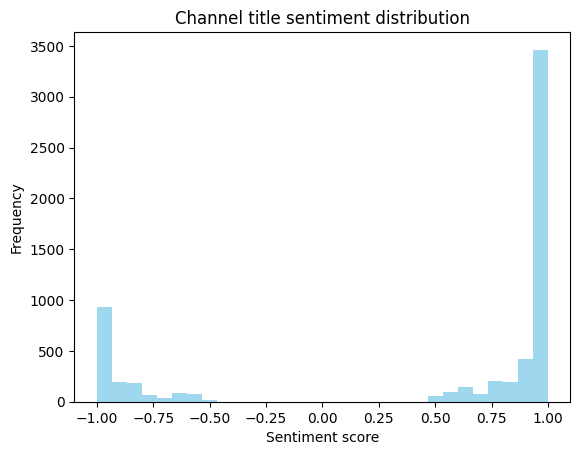

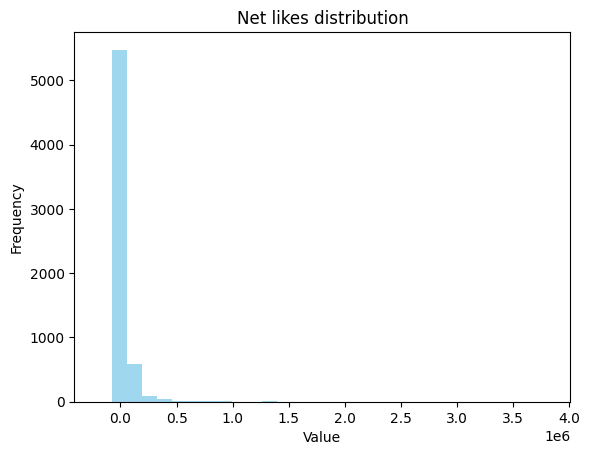

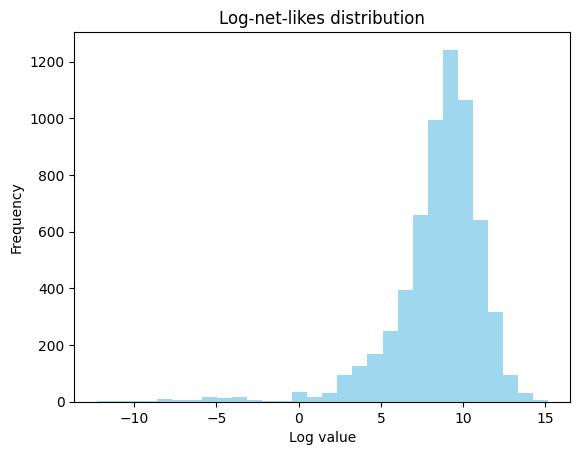

In [27]:
# visualizing the sentiment and log-net like features
import matplotlib.pyplot as plt
import numpy as np

titleSentiCol = usVideosSenti[senti_cols[0]]
chntilSentiCol = usVideosSenti[senti_cols[1]]
logNetLikeCol = usVideosSenti["net_likes"]
oriLogNetLikeCol = usVideosSenti["ori_net_likes"]

plt.hist(titleSentiCol, bins=30, color='skyblue', alpha=0.8)
plt.title('Title sentiment distribution')
plt.xlabel('Sentiment score')
plt.ylabel('Frequency')
plt.show()

plt.hist(chntilSentiCol, bins=30, color='skyblue', alpha=0.8)
plt.title('Channel title sentiment distribution')
plt.xlabel('Sentiment score')
plt.ylabel('Frequency')
plt.show()

plt.hist(oriLogNetLikeCol, bins=30, color='skyblue', alpha=0.8)
plt.title('Net likes distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

plt.hist(logNetLikeCol, bins=30, color='skyblue', alpha=0.8)
plt.title('Log-net-likes distribution')
plt.xlabel('Log value')
plt.ylabel('Frequency')
plt.show()

# plt.scatter(oriLogNetLikeCol, titleSentiCol)
# plt.show()


# Model construction

## PCA + MLP

In [79]:
# Determine dataset partitions and labels
size = len(usVideosCleaned)
print(size)
test_size = size // 4
train_size = size - test_size
partitions = {"train": usVideosCleaned["video_id"][:train_size].to_list(), 
              "test": usVideosCleaned["video_id"][train_size:].to_list()}
labels = dict(zip(partitions["train"]+partitions["test"], usVideosCleaned["net_likes"])) # classifying whether the video is popular
# print(partitions)
# print(labels)


6254


In [80]:
# Do dimensionality reduction to extract key features
from sklearn.decomposition import PCA
import pandas as pd
# from copy import copy

def pca_decompose(ds, n_components=5):
    if (n_components==8):
        return ds
    vid = ds["video_id"].to_list()
    ds = ds.drop(columns=["video_id"])
    print("Before PCA: {}".format(ds.shape))  
    # print(ds)  
    pca = PCA(n_components=n_components)
    ds_pca = pca.fit_transform(ds)
    print("After PCA: {}".format(ds_pca.shape))  
    ds_pca = pd.DataFrame(ds_pca)
    ds_pca["video_id"] = vid
    # print(ds_pca)  
    return ds_pca


In [81]:
# Dataset definitions
import torch

params = {'batch_size': 64,'shuffle': True,'num_workers': 6}
# id_col = usVideosCleaned["video_id"] 
label_col = usVideosCleaned["net_likes"] 
# usVideosCleaned = usVideosCleaned.drop(columns=["net_likes", "video_id"])
usVideosCleanedFeats = usVideosCleaned.drop(columns=["net_likes"])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, list_ids, labels, data):
        self.data = data
        self.labels = labels
        self.list_ids = list_ids
    def __len__(self):
        """Denoting the total number of samples"""
        # print("getting len {}".format(len(self.list_ids)))
        # print(len(self.list_ids))
        return len(self.list_ids)
    def __getitem__(self, index):
        """generator fetching one data and one label. Return: X, y"""
        # print(self.data)
        # print(self.data["video_id"])
        curr_id = self.list_ids[index]
        y = self.labels[curr_id]
        X = self.data.loc[self.data["video_id"]==curr_id, :]
        X = X.drop(columns=["video_id"])
        X = X.to_numpy()
        # X = X.astype(np.float32)
        # print(X, y)
        # print(X.shape, X.dtype, type(y))
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Dataset Preparations
def prepare_usvideos_dataset(labels, data, partition, params=params):
    training_set = Dataset(partition['train'], labels, data)
    training_generator = torch.utils.data.DataLoader(training_set, **params)
    test_set = Dataset(partition['test'], labels, data)
    test_generator = torch.utils.data.DataLoader(test_set, **params)
    return training_generator, test_generator
        
dataset_params = {'batch_size': 1024,'shuffle': True,'num_workers': 0}
print("Dataset size: {}".format(len(usVideosCleanedFeats)))
usVideosCleanedFeats = pca_decompose(usVideosCleanedFeats)
train_dl, test_dl = prepare_usvideos_dataset(labels, usVideosCleanedFeats, partitions, params=dataset_params)

print(usVideosCleanedFeats.columns)
print("Feature dim: {}".format(len(usVideosCleanedFeats.columns)))
# print(len(train_dl.dataset),len(test_dl.dataset))

Dataset size: 6254
Before PCA: (6254, 10)
After PCA: (6254, 5)
Index([0, 1, 2, 3, 4, 'video_id'], dtype='object')
Feature dim: 6


In [28]:
import torch

In [98]:
# MLP definitions
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, in_dim=8, out_dim=1):
        super(MLP, self).__init__()
        assert out_dim==1, 'out_dim must be 1'
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.conv1 = torch.nn.Conv1d(in_dim, 64, 1) # local feature extraction layers
        self.bnConv1 = nn.BatchNorm1d(64)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.bnConv2 = nn.BatchNorm1d(128)
        self.conv3 = torch.nn.Conv1d(128, 256, 1)
        self.bnConv3 = nn.BatchNorm1d(256)
        self.conv4 = torch.nn.Conv1d(256, 512, 1)
        self.bnConv4 = nn.BatchNorm1d(512)
        self.conv5 = torch.nn.Conv1d(512, 1024, 1)
        self.bnConv5 = nn.BatchNorm1d(1024)
        self.linear0 = nn.Linear(1024, 512)
        self.bnLin0 = nn.BatchNorm1d(512)
        self.linear1 = nn.Linear(512, 256)
        self.bnLin1 = nn.BatchNorm1d(256)
        self.linear2 = nn.Linear(256, 128)
        self.bnLin2 = nn.BatchNorm1d(128)
        self.linear3 = nn.Linear(128, 64)
        self.bnLin3 = nn.BatchNorm1d(64)
        self.linear4 = nn.Linear(64, self.out_dim)
    def forward(self, x):
        # print("stt", x.shape)
        x = torch.permute(x, (0, 2, 1))
        x = F.relu(self.bnConv1(self.conv1(x)))
        # print("lin1pass", x.shape)
        x = F.relu(self.bnConv2(self.conv2(x)))
        # print("lin2pass", x.shape)
        x = F.relu(self.bnConv3(self.conv3(x)))
        x = F.relu(self.bnConv4(self.conv4(x)))
        x = F.relu(self.bnConv5(self.conv5(x)))
        x = torch.permute(x, (0, 2, 1))
        # print(x.shape)
        # print(self.linear1(x).shape)
        # x = torch.permute(x, (0, 2, 1))
        x = F.relu(self.linear0(x))
        x = F.relu(self.linear1(x))
        # x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return torch.squeeze(x)
    

In [99]:
# Model training stuffs
import time
import torch
import os

def train_model(train_dl, model, epochs=100, lr=0.01, momentum=0.9, save_step=10, save_dir='models'):
    # Define your optimisation function for reducing loss when weights are calculated 
    # and propogated through the network
    start = time.time()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss = 0.0

    for epoch in range(epochs):
        model.train()
        # print('train mode entered')
        # Iterate through training data loader
        losses = []
        for i, (inputs, targets) in enumerate(train_dl):
            # print(inputs.shape, targets.shape)
            optimizer.zero_grad()
            # print("sttinp")
            outputs = model(inputs)
            # print("getout")
            # _, preds = torch.max(outputs.data,1) #Get the class labels
            # print(outputs, targets)
            loss = criterion(outputs, targets)
            losses.append(loss.item())
            # print("getloss")
            loss.backward()
            # print("bgprob")
            optimizer.step()
        epoch_loss = sum(losses)/len(losses)
        if (epoch%save_step==0):
            print("Saving model at step {}".format(epoch+1))
            save_path = os.path.join(save_dir, "model_{}.pth".format(epoch))
            torch.save(model.state_dict(), save_path)
        print('Epoch {}/{}. MSE Loss {}'.format(epoch+1, epochs, epoch_loss))
        # print('-' * 10)
    time_delta = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_delta // 60, time_delta % 60
    ))
    save_path = os.path.join(save_dir, "model_final.pth")
    print("Final save of model to {}.".format(save_path))
    torch.save(model.state_dict(), save_path)
    return model

In [102]:
# Build the model
model = MLP(in_dim=5)
train_model(train_dl, model, 
            save_step=10, 
            save_dir='models',
            epochs=500, 
            lr=5e-4)


Saving model at step 1
Epoch 1/500. MSE Loss 70.5665283203125
Epoch 2/500. MSE Loss 67.08286743164062
Epoch 3/500. MSE Loss 61.360982513427736
Epoch 4/500. MSE Loss 51.98013458251953
Epoch 5/500. MSE Loss 32.15555686950684
Epoch 6/500. MSE Loss 16.63665180206299
Epoch 7/500. MSE Loss 11.247413444519044
Epoch 8/500. MSE Loss 10.990123748779297
Epoch 9/500. MSE Loss 9.543830871582031
Epoch 10/500. MSE Loss 8.289779090881348
Saving model at step 11
Epoch 11/500. MSE Loss 7.793470287322998
Epoch 12/500. MSE Loss 7.9109947204589846
Epoch 13/500. MSE Loss 7.7007238388061525
Epoch 14/500. MSE Loss 7.663689994812012
Epoch 15/500. MSE Loss 7.414126300811768
Epoch 16/500. MSE Loss 7.470429229736328
Epoch 17/500. MSE Loss 7.44126787185669
Epoch 18/500. MSE Loss 7.29853458404541
Epoch 19/500. MSE Loss 7.380317211151123
Epoch 20/500. MSE Loss 7.249142742156982
Saving model at step 21
Epoch 21/500. MSE Loss 7.206669807434082
Epoch 22/500. MSE Loss 7.2600147247314455
Epoch 23/500. MSE Loss 6.94694261

MLP(
  (conv1): Conv1d(5, 64, kernel_size=(1,), stride=(1,))
  (bnConv1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (bnConv2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
  (bnConv3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
  (bnConv4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
  (bnConv5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear0): Linear(in_features=1024, out_features=512, bias=True)
  (bnLin0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (bnLi

# Model evaluations

## Net_like prediction

In [103]:
# Model evaluation stuffs
import math
import torch
import numpy as np

def predict(row, model):
    row = torch.Tensor([row])
    yhat = model(row)
    # Get numpy array
    yhat = yhat.detach().numpy()
    return yhat  

def evaluate_model(test_dl, model, beta=1.0):
    preds = np.zeros((len(test_dl.dataset)))
    actuals = np.zeros((len(test_dl.dataset)))
 
    curr_ind = 0
    for (i, (inputs, targets)) in enumerate(test_dl):
        # print(inputs.shape, targets.shape)
        #Evaluate the model on the test set
        yhat = model(inputs)
        #Retrieve a numpy weights array
        yhat = yhat.detach().numpy()
        # Extract the weights using detach to get the numerical values in an ndarray, instead of tensor
        targets = targets.numpy()
        # Round to get the class value i.e. sick vs not sick
        # yhat = yhat.round()
        # Store the predictions in the empty lists initialised at the start of the class
        # print(yhat.shape, targets.shape)
        # print(preds.shape, actuals.shape)
        batch_size = len(yhat)
        preds[curr_ind:curr_ind+batch_size] = yhat
        actuals[curr_ind:curr_ind+batch_size] = targets
        curr_ind += batch_size
     
    return preds, actuals

def get_model_eval_metrics(test_dl, model_path, in_dim):
    model = MLP(in_dim=in_dim)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return evaluate_model(test_dl, model)
    
    

In [104]:
# Determine dataset partitions and labels
size = len(usVideosCleaned)
print(size)
test_size = size // 4
train_size = size - test_size
partitions = {"train": usVideosCleaned["video_id"][:train_size].to_list(), 
              "test": usVideosCleaned["video_id"][train_size:].to_list()}
labels = dict(zip(partitions["train"]+partitions["test"], usVideosCleaned["net_likes"])) # classifying whether the video is net_likes
# print(partitions)

# print(labels)


6254


In [105]:
# Comparing MLP performance with and without PCA
import matplotlib.pyplot as plt
import numpy as np 

def scale_back(pred, act):
    f = lambda x: np.exp(x) if x>0 else -np.exp(-x)
    pred = np.array(list(map(f, pred)))
    act = np.array(list(map(f, act)))
    return pred, act

# Get overall evaluations
model_no_pca_path = "models/mlp_dense/model_final.pth"
pca_model_paths = [model_no_pca_path]
input_dims = [5]
for p, d in zip(pca_model_paths, input_dims):
    # Determine datasets for different number of PCA components
    label_col = usVideosCleaned["net_likes"] 
    usVideosCleanedFeats = usVideosCleaned.drop(columns=["net_likes"])
    usVideosCleanedFeats = pca_decompose(usVideosCleanedFeats, n_components=5)
    _, test_dl = prepare_usvideos_dataset(labels, usVideosCleanedFeats, partitions, params=dataset_params)

    # Evaluate to get metrics
    pred, act = get_model_eval_metrics(test_dl, p, in_dim=d)
    pred, act = scale_back(pred, act)
    # print(pred)
    # print(act)
    mse = np.mean((pred-act)**2)
print("mse: {}".format(mse))


Before PCA: (6254, 10)
After PCA: (6254, 5)
mse: 25353674859.47385
